<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Get-information-from-GFF-file" data-toc-modified-id="Get-information-from-GFF-file-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Get information from GFF file</a></span><ul class="toc-item"><li><span><a href="#Convert-GFF-to-Pandas-DataFrame" data-toc-modified-id="Convert-GFF-to-Pandas-DataFrame-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Convert GFF to Pandas DataFrame</a></span></li><li><span><a href="#Check-genes" data-toc-modified-id="Check-genes-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Check genes</a></span></li><li><span><a href="#Generate-nucleotide-fasta-files-for-CDS" data-toc-modified-id="Generate-nucleotide-fasta-files-for-CDS-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Generate nucleotide fasta files for CDS</a></span></li></ul></li><li><span><a href="#Get-COGs" data-toc-modified-id="Get-COGs-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get COGs</a></span><ul class="toc-item"><li><span><a href="#Run-EggNOG-Mapper" data-toc-modified-id="Run-EggNOG-Mapper-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Run EggNOG Mapper</a></span></li><li><span><a href="#Add-COG-class-and-KEGG-orthology" data-toc-modified-id="Add-COG-class-and-KEGG-orthology-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Add COG class and KEGG orthology</a></span></li><li><span><a href="#Uniprot-ID-mapping" data-toc-modified-id="Uniprot-ID-mapping-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Uniprot ID mapping</a></span></li></ul></li><li><span><a href="#Clean-up-and-save-annotation" data-toc-modified-id="Clean-up-and-save-annotation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Clean up and save annotation</a></span><ul class="toc-item"><li><span><a href="#Final-statistics" data-toc-modified-id="Final-statistics-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Final statistics</a></span></li><li><span><a href="#Fill-missing-values" data-toc-modified-id="Fill-missing-values-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Fill missing values</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys,os
from Bio import SeqIO
sys.path.append('../modulome/')

In [2]:
from modulome.config import *
from modulome.util import *

In [3]:
organism = 'Sulfolobus_acidocaldarius'
kegg_organism_code = 'sai'

In [4]:
org_dir = os.path.join(DATA_DIR,'organisms',organism)
seq_dir = os.path.join(org_dir,'sequence_files')

# Get information from GFF file

## Convert GFF to Pandas DataFrame
Code is borrowed from modulome-nextflow to make sure dataframes will work with log-tpm files

In [5]:
annot_list = []
for filename in os.listdir(seq_dir):
    if filename.endswith('.gff3'):
        gff = os.path.join(seq_dir,filename)
        annot_list.append(gff2pandas(gff))
keep_cols = ['refseq','start','end','strand','gene_name','locus_tag','old_locus_tag','gene_product','ncbi_protein']
DF_annot = pd.concat(annot_list)[keep_cols]
DF_annot.set_index('locus_tag',drop=True,inplace=True)

# Some gene products have commas in the name, which are represented by %2C. 
# Should we change this or keep this as is? (i.e. 2,3-butanediol)

In [6]:
DF_annot.head()

,refseq,start,end,strand,gene_name,old_locus_tag,gene_product,ncbi_protein
locus_tag,,,,,,,,
SACI_RS00005,NC_007181.1,101,1261,+,None,Saci_0001,AAA family ATPase,WP_011276932.1
SACI_RS00010,NC_007181.1,1294,1629,+,None,Saci_0002,hypothetical protein,WP_011276933.1
SACI_RS00015,NC_007181.1,1665,2504,+,None,Saci_0003,hypothetical protein,WP_011276934.1
SACI_RS00020,NC_007181.1,2553,3056,-,None,Saci_0004,hypothetical protein,WP_015385334.1
SACI_RS00025,NC_007181.1,3049,3768,-,None,Saci_0005,hypothetical protein,WP_011276936.1


## Check genes

In [7]:
tpm_file = os.path.join(org_dir,'log_tpm.csv')
DF_log_tpm = pd.read_csv(tpm_file,index_col=0)

In [8]:
# Check that the genes are the same in the expression dataset as in the annotation dataframe.
# Mismatched genes are listed below
test = DF_annot.sort_index().index == DF_log_tpm.sort_index().index
DF_annot[~test]

,refseq,start,end,strand,gene_name,old_locus_tag,gene_product,ncbi_protein
locus_tag,,,,,,,,


## Generate nucleotide fasta files for CDS

In [14]:
cds_list = []
for filename in os.listdir(seq_dir):
    if filename.endswith('.fasta'):
        fasta = os.path.join(seq_dir,filename)
        seq = SeqIO.read(fasta,'fasta')
        
        # Get gene information for genes in this fasta file
        df_genes = DF_annot[DF_annot.refseq == seq.id]
        for i,row in df_genes.iterrows():
            cds = seq[row.start-1:row.end]
            if row.strand == '-':
                cds = seq[row.start-1:row.end].reverse_complement()
            cds.id = row.name
            cds.description = row.gene_name if pd.notnull(row.gene_name) else row.name
            cds_list.append(cds)

In [15]:
SeqIO.write(cds_list,os.path.join(seq_dir,'CDS.fna'),'fasta')

2296

# Get COGs

## Run EggNOG Mapper
1. Go to [http://eggnog-mapper.embl.de/].
1. Upload the CDS.fna file from your organism directory (within the sequence_files folder)
1. Make sure to limit the taxonomy to the correct level
1. After the job is submitted, you must follow the link in your email to run the job.
1. Once the job completes (after ~4 hrs), download the annotations file.
1. Save the annotation file to `data/eggNOG/<organism_name>.annotations`

## Add COG class and KEGG orthology

In [16]:
DF_eggnog = pd.read_csv(os.path.join(DATA_DIR,'eggNOG',organism+'.annotations'),sep='\t',skiprows=4,header=None)
eggnog_cols = ['query_name','seed eggNOG ortholog','seed ortholog evalue','seed ortholog score',
               'Predicted taxonomic group','Predicted protein name','Gene Ontology terms',
               'EC number','KEGG_ko','KEGG_Pathway','KEGG_Module','KEGG_Reaction',
               'KEGG_rclass','BRITE','KEGG_TC','CAZy','BiGG Reaction','tax_scope',
               'eggNOG OGs','bestOG_deprecated','COG','eggNOG free text description']
DF_eggnog.columns = eggnog_cols
# Strip last three rows as they are comments
DF_eggnog = DF_eggnog.iloc[:-3]

# Set locus tag as index
DF_eggnog = DF_eggnog.drop_duplicates('query_name').set_index('query_name')
DF_eggnog.index.name = 'locus_tag'

# Only keep KEGG orthology and COG
DF_eggnog = DF_eggnog[['KEGG_ko','COG']]

In [17]:
DF_eggnog.head()

,KEGG_ko,COG
locus_tag,,
SACI_RS00005,ko:K10725,L
SACI_RS00010,NaN,NaN
SACI_RS00015,NaN,S
SACI_RS00020,NaN,NaN
SACI_RS00025,NaN,NaN


In [18]:
DF_annot_cog = pd.concat([DF_annot,DF_eggnog],axis=1,sort=False)
DF_annot_cog.index.name = 'locus_tag'
assert(len(DF_annot_cog) == len(DF_annot))

## Uniprot ID mapping

In [20]:
# Try the uniprot ID mapping tool - Use EMBL for Genbank file and P_REFSEQ_AC for Refseq file
mapping_uniprot = uniprot_id_mapping(DF_annot.ncbi_protein.fillna(''),input_id='P_REFSEQ_AC',output_id='ACC',
                             input_name='ncbi_protein',output_name='uniprot')

# Merge with current annotation
DF_annot_cog_uniprot = pd.merge(DF_annot_cog.reset_index(),mapping_uniprot,how='left',on='ncbi_protein')
DF_annot_cog_uniprot.set_index('locus_tag',inplace=True)
assert(len(DF_annot) == len(DF_annot_cog_uniprot))

In [21]:
DF_annot_cog_uniprot.head()

,refseq,start,end,strand,gene_name,old_locus_tag,gene_product,ncbi_protein,KEGG_ko,COG,uniprot
locus_tag,,,,,,,,,,,
SACI_RS00005,NC_007181.1,101,1261,+,None,Saci_0001,AAA family ATPase,WP_011276932.1,ko:K10725,L,A0A0U3H3T6
SACI_RS00010,NC_007181.1,1294,1629,+,None,Saci_0002,hypothetical protein,WP_011276933.1,NaN,NaN,A0A0U3FP71
SACI_RS00015,NC_007181.1,1665,2504,+,None,Saci_0003,hypothetical protein,WP_011276934.1,NaN,S,A0A0U2NAH6
SACI_RS00020,NC_007181.1,2553,3056,-,None,Saci_0004,hypothetical protein,WP_015385334.1,NaN,NaN,A0A0U3HCE5
SACI_RS00025,NC_007181.1,3049,3768,-,None,Saci_0005,hypothetical protein,WP_011276936.1,NaN,NaN,A0A0U3FGW8


# Clean up and save annotation

In [27]:
# Temporarily remove warning
pd.set_option('mode.chained_assignment', None)

In [28]:
order = ['gene_name','start','end','strand','gene_product','uniprot','COG','KEGG_ko']
DF_annot_final = DF_annot_cog_uniprot[order]
# Strip "ko:" from KEGG orthologies
DF_annot_final['KEGG_ko'] = [item[3:] if isinstance(item,str) else item for item in DF_annot_final['KEGG_ko']]
# Only include one COG group
DF_annot_final['COG'] = [item[0] if isinstance(item,str) else item for item in DF_annot_final['COG']]

In [29]:
DF_annot_final.head()

,gene_name,start,end,strand,gene_product,uniprot,COG,KEGG_ko
locus_tag,,,,,,,,
SACI_RS00005,None,101,1261,+,AAA family ATPase,A0A0U3H3T6,L,K10725
SACI_RS00010,None,1294,1629,+,hypothetical protein,A0A0U3FP71,NaN,NaN
SACI_RS00015,None,1665,2504,+,hypothetical protein,A0A0U2NAH6,S,NaN
SACI_RS00020,None,2553,3056,-,hypothetical protein,A0A0U3HCE5,NaN,NaN
SACI_RS00025,None,3049,3768,-,hypothetical protein,A0A0U3FGW8,NaN,NaN


## Final statistics

In [30]:
sns.set_style('ticks')

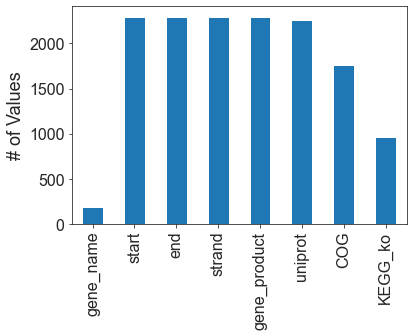

In [31]:
fig,ax = plt.subplots()
DF_annot_final.count().plot(kind='bar',ax=ax)
ax.set_ylabel('# of Values',fontsize=18)
ax.tick_params(labelsize=16)

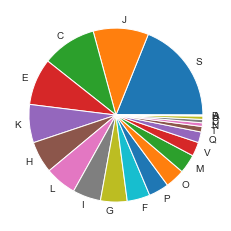

In [32]:
counts = DF_annot_final.COG.value_counts()
plt.pie(counts.values,labels=counts.index);

## Fill missing values

In [33]:
# Fill in missing gene names with locus tag names
DF_annot_final['tmp_name'] = DF_annot_final.copy().index.tolist()
DF_annot_final.gene_name.fillna(DF_annot_final.tmp_name,inplace=True)
DF_annot_final.drop('tmp_name',axis=1,inplace=True)

# Fill missing COGs with X
DF_annot_final['COG'].fillna('X',inplace=True)

In [25]:
DF_annot_final.to_csv(os.path.join(DATA_DIR,'organisms',organism,'gene_info.csv'))